# **Project: Classically verifiable quantum advantage from a computational Bell test**

**Develped and authored by team members of QUIP:** Filippo Tramonto, Ban Tran, Nahid Binandeh Dehaghani

(All Notebook text is written by Filippo Tramonto, execpt where is specified otherwise)

## **Requirements of Project Step 2**
The second step consisists in enlarging the eproblem for a more complicated scenario. In this step, the actual problems from the papers should be implemented. Resources estimation in terms of circuit depth, circuit width and number of 2-qubit gates should be made and compared across several hardwares.


## **Implementation of the Project Step 2**

The more complicated scenario for us consists in the implemenation of the whole protocol described by the paper. Thus implmennting both the quantum steps and the classical steps of the interactive quantum advantage protocol.

We developed all the  functions for all protocol steps from scratch, except the protocol step 2 that we covered in the jupyter notebook Step 1.





## Scheme of the protocol
Here the schematic representation of the interactive quantum advantage protocol

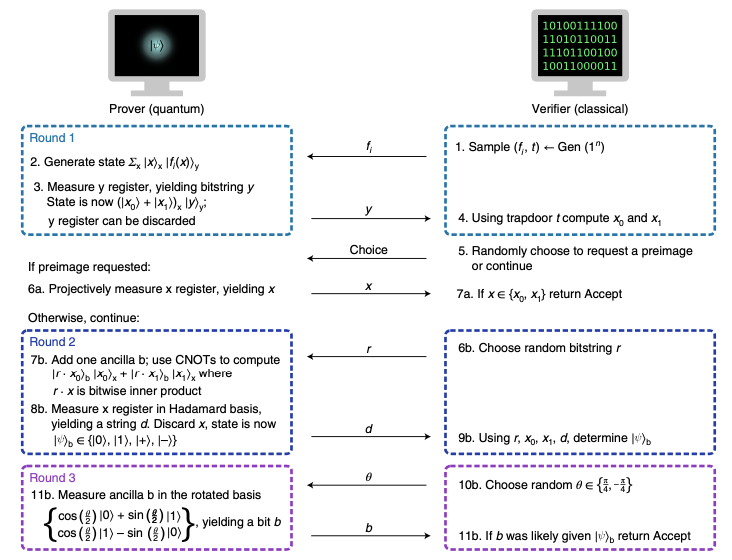


### Module imports and package installation

In [ ]:
## TIP : run this cell 2 times, when you run this notebook on Colab or other enviroment where classiq pacckage is not installed
##       the second time removes the annoying installation log prints
try:
    import classiq
except ImportError:
    print("installing classiq...")
    !pip install classiq
    import classiq
    print("installed classiq!")

# other imports
from classiq import *
import numpy as np
import random
import math

# Round 1

The goal of the first round is to generate a superposition over two colliding inputs to a Trapdoor Claw-Free Function (TCF). The (classical) verifier choose an instance $f_i$ of the TCFs and the trapdoor data $t$. The $f_i$ is then sent to prover.

As TCF we use $x^2 \!\!\! \mod \!\! N$ with $i$ is $N$ and $t$ data dare the  primes $p$ and $q$, factors of $N$, $N=p q$, i.e. $f_i(x) =x^2 \!\!\! \mod \!\! N$.

The (quantum) prover prepares the two quantum register $x$ and $y$ in the superposition $ |\psi \rangle =\sum _{x}\left| x\rangle _{x}\right| f_{i}\left( x\right) \rangle _{y}$.
The prover then measures the y register in the standard basis, collapsing the state to $\left( | x_{0}\rangle +| x_{1}\rangle \right) _{k}| y\rangle _{y}$ with $ y=f\left( x_{0}\right) =f\left( x_{1}\right)$.
The measured bitstring $y$ is then sent to the verifier to use trapdoor for computing $x_0$ and $x_1$.
The trapdoor data for the Rabin's TCF function are the prime numbers $p$ and $q$ factors of $N$.

(Text by Filppo Tramonto, Nahid Binandeh Dehaghani)

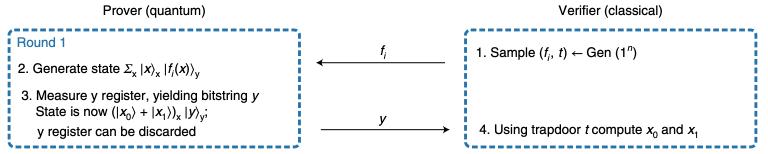

## Protocol Step 1

### Function `gen_1lambda`

The first step consists sampling the Trapdoor Claw Free (TCF) functions $f_i$ and the associated trapdoor data $t$.

In the paper, the function that generates $f_i$ and $t$ is $\textrm{Gen}(1^\lambda)$ that, in the case of the TCF family of Rabin ($x^2 \!\!\!\! \mod \!\! N$), takes as input the number of bits needed to represent $N$ and returns a sample of $N$ and the 2 primes, $p$ and $q$ factors of $N$.

For the paper it should return the function $f_i$, but in the case of the Rabin function, $f_i$ is represented by $N$ because the index $i$ is $N$.

### Implementaion of `gen_1lambda`

For the actual implementation consists in choosing randomly 2 prime numbers, $p$ and $q$ with the number of bits that is the half of the number of bits for representing the modulus $N$.
I followed the defintion given in the paragraph "TCF from Rabin's function x^2 mod N" of Methods section of the paper (on Nature Physics).
From the defintion the Rabin's TCF functions given in the paper, $p$ and $q$ have to be $≡ 3\!\!\!\! \mod \!\! 4$, i.e. $= 4k + 3$, for some non negative integer $k$, so we can choose 2 random values for $k$ and apply the latter formula, then check if $p$ and $q$ are primes, if not, re-sample them until 2 primes satisfying the requirements are found. To generate the 2 primes with the required lenght of bits in input, $n$ , $k$ has to be sampled from the range $[0,2^{n-2}-1]$.

### Function definition (function name: `gen_1lambda`)

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################

#To implement this function I followed the paragraph "TCF from Rabin's function x^2 mod N" of Methods section of the paper.

def is_prime(p):           # function to check if p and are q are primes
    for l in range(2,p):
        if p % l == 0:
            return False
    return True

def gen_1lambda(n): # n is the number of bits of each prime (n = lamda/2, of the paper)

    while True:
        k1 = random.randrange(2**(n-2)) # k in {0,1,...,2^(n-2)-1} in order to have primes 3 mod 4 with n bits
        k2 = random.randrange(2**(n-2))
        while k2 == k1:
          k2 = random.randrange(2**(n-2))
        p = 4*k1 + 3
        q = 4*k2 + 3
        if is_prime(p) and is_prime(q):
            break

    N = p *q

    return N, p, q  # return N, because N represents the function f_i

## example of execution of gen_1lambda
N, p, q = gen_1lambda(3)
print(f"N= {N}, p= {p}, q= {q}")

N= 21, p= 3, q= 7


## Protocol Step 2

#### Code of phase circuit "fast" implmented in Classiq Python SDK

Here we present the whole implementation of the phase circuit "fast" (Gate-optimized) described in the paper. Detailed explanations of the implementaion are given in the notebook of Step 1.

In [ ]:
from classiq.qmod.symbolic import pi

@qfunc
def x2_mod_N_phase(x: QArray[QBit], y: QArray[QBit]) -> None:

    # Apply Hadamard gates to all qubits in x and y
    hadamard_transform(x)  # Apply Hadamard transform
    hadamard_transform(y)  # Apply Hadamard transform

    x2modN_fast(x, y, N)
    iqft_custom(y)

def x2modN_fast(x: QArray[QBit], y: QArray[QBit], N: int) -> None:

    counter = QArray("counter")
    allocate(n_counter, counter)

    hadamard_transform(counter)

    for l in range(2*n_x -1):
        qubit_pairs = [(i, l-i) for i in range(max(0, l-n_x+1), l//2 + 1)]

        count(x, counter, qubit_pairs, sign= 1)
        iqft_custom(counter)

        for k in range(n_counter):
            phase = 2 * 2**(k+l) / N
            phase_add_1qubit(phase, y, counter[k])

        # uncompute
        qft_custom(counter)
        count(x, counter, qubit_pairs, sign= -1)

    hadamard_transform(counter)

@qfunc
def qft_custom(reg: QArray[QBit]):
    # outer loop with index k
    repeat(count=reg.len,
          iteration= lambda k: qft_outer_iteration(k,reg) )

@qfunc
def qft_outer_iteration(k: CInt, reg: QArray[QBit]):
    kk = reg.len -k -1  # to have the loop in reverse order (from reg.len-1 to 0)
    # inner loop with index m
    repeat(count=reg.len-kk-1,    # in the orginal function the total number of iterations is len(reg)-k-1
          iteration= lambda m: qft_inner_iteration(m, kk, reg) )
    H(reg[kk])

@qfunc
def qft_inner_iteration(m: CInt, kk: CInt, reg: QArray[QBit]):
    mm = m + kk +1    # to have the original index m that starts from k+1
    phase = 1/2**(mm-kk)
    MCZPhase(phase, reg[mm], reg[kk])

@qfunc
def iqft_custom(reg: QArray[QBit]):
    invert(lambda: qft_custom(reg))

def count(x: QArray[QBit], counter: QArray[QBit], pairs, sign) -> None:
    # Loop the array of qubit index pairs to set 1 or 2 qubits of x register as controls register. For example, the array could be [(1,2), (1, 3), (0,2)]
    for i,j in pairs:
        if i == j:
            # If two indexes are equal, set x[i] qubit as controls qubit
            fctr = 1
            # Calculate phase for the phase_add_1qubit function
            phase = sign *fctr *(2**(1-counter.len))
            # Call the phase_add_1qubit function
            phase_add_1qubit(phase, counter, x[i])
        else:
            # If two indexes are different, set 2 qubits x[i] and x[j] as the controls
            fctr = 2
            # Calculate phase for the phase_add_2qubits function
            phase = sign *fctr *(2**(1-counter.len))
            # Call the phase_add_2qubits function
            phase_add_2qubits(phase, counter, x[i], x[j])

@qfunc
def phase_add_2qubits(in_phase: CReal, target: QArray[QBit], control1: QBit, control2: QBit) -> None:
    controls = QArray('controls')
    bind([control1, control2],controls)
    repeat(count = target.len,
           iteration = lambda k: phase_add_iteration(k,in_phase,target,controls))
    bind(controls,[control1, control2])

@qfunc
def phase_add_1qubit(in_phase: CReal, target: QArray[QBit], control: QBit) -> None:
    repeat(count = target.len,
           iteration = lambda k: phase_add_iteration(k,in_phase,target,control))

@qfunc
def phase_add_iteration(k: CInt, in_phase: CReal, target: QArray[QBit], controls: QArray[QBit]) -> None:
    phase = 2**(target.len -k -1)* in_phase % 2
    MCZPhase(phase, target[k], controls)   # target[k] is yk-th qubit of target in orgiginal code


@qfunc
def MCZPhase(phase: CReal, target: QBit, controls: QArray[QBit]):
    theta = phase * pi
    control(controls, lambda: PHASE(theta , target))

## Protocol Step 3


This step is the measurement of the $y$ register producing a value $y$ that will take as input from the step 4 to classically compute $x_0$ and $x_1$.

Since Classiq platorm does not support mid-circuit measurement, we opted to make all the measurement at the end of quantum prover steps.

This measurement is implemented in the final code that implments the whole protocol. In the code there is also all the redout and post-processing.

## Protocol Step 4




This protocol step consists in the computation of the two values $x_0$ and $x_1$ of the domain of the TCF Rabin's function $x^2 \!\!\! \mod \!\! N$, from the measured value of $y$ (from the protocol step 3) and the two primes $p$, $q$, factors of $N$.

The implemntation of this function is a naive implemntation, not very efficient, since it evaluates all the possible values of $y = x^2 \!\!\! \mod \!\! N$ for whole range of $x$, and then select $x$ values corrosponding to the input $y$.
However this implementation is very general and does not depend from the special values of the prime numbers, required by the defintion of the Rabin's function (see the Methods, and Supplementary Information sections of the paper).

Here the range used for $x$  is not limited by domain of the Rabin's function ($[0,N/2]$), but it extends to the actual range of values of the $x$ quantum register.
In this way we can check if the measured $y$, obtained from the quantum circuit, is a valid $y$ corresponding to exaclty 2 values of $x$ in the domain of the Rabin's function.

If we do not perform this check, can happen to obtain measured values of $y$ corresponding to only one value of $x$, or to 3 or more values of $x$, in the actual range of the quantum register (that in general is not limited by the domain of the Rabin's function). This occurence would make the protocol not apllicable. The quantum state would not collapse to the suporpostion of the two states, $(|x_0\rangle + |x_1\rangle)_x | y \rangle_y $, after the measurement of $y$ register of the protocol step 3, but would collapse to a single state, or to a superpostion of 3 or more states.

If the input $y$ is not valid, it will be discarded.


### Function defintion (function name: `compute_x0x1`)

In [ ]:
############## Developed by #########################
# Nahid Binandeh Dehaghani
############## Reviewed and edited by ##############
# Ban Tran, Filippo Tramonto
####################################################
# Function to compute x0 and x1 for a given y, p, and q
def compute_x0x1(y, p, q):
    N = p * q    # Compute N from p and q
    y_dict = {}  # Dictionary to store y values with corresponding x values

    domain_max = (N+1)//2 - 1
    n_x = n_x = domain_max.bit_length()
    # Compute y for all x values in the range [0, 2^n_x)
    for x in range(2**n_x):
        computed_y = x**2 % N
        y_dict.setdefault(computed_y, []).append(x)

    # Find x0 and x1 for the specific y value, and discard them if the condition below does not hold
    if y in y_dict and len(y_dict[y]) == 2 and y_dict[y][0] < N/2 and y_dict[y][1] < N/2 :
        return y_dict[y][0], y_dict[y][1]
    else:
        return None

### Test of the function `compute_x0x1`

In [ ]:
############## Developed by #########################
# Nahid Binandeh Dehaghani
###################################################
### Ban Tran: Nahid used to test the core function. It will be deleted when the whole protocol is finished ######
#Function to print all computed y values and their corresponding x values
def print_all_values(p, q):
    N = p * q  # Compute N from p and q
    y_dict = {}  # Dictionary to store y values with corresponding x values

    # Compute y for all x values in the range [0, N/2)
    for x in range(N // 2):
        computed_y = x**2 % N
        y_dict.setdefault(computed_y, []).append(x)

    # Print all y values and their corresponding x values
    for y, x_values in y_dict.items():
        if len(x_values) > 1:
            x0, x1 = x_values
            print(f"For y = {y}, the pairs are x0 = {x0} and x1 = {x1}")
        else:
            print(f"For y = {y}, there is only one x: x = {x_values[0]}")

# Function to test compute_x0x1
def test_compute_x0x1(y, p, q):
    result = compute_x0x1(y, p, q)
    if result:
        x0, x1 = result
        print(f"For y = {y}, the pairs are x0 = {x0} and x1 = {x1}, p is {p}, q is {q}")
    else:
        print(f"No pairs found for y = {y}")
        x0 = x1 = 0
    return x0, x1

# Print all values
print_all_values(p, q)

# Example usage: Manually input the specific y value, p, and q to test the function
# Note: Ensure the y value is in decimal format. If y is in binary, convert it to decimal.
input_y = input("Enter the specific y value (binary or decimal): ")
if input_y.startswith('0b'):
    y = int(input_y, 2)  # Convert binary string to decimal
else:
    y = int(input_y)  # Assume the input is already in decimal format

#p = int(input("Enter the prime number p: ")) # commented because they are already genarated from gen_1lamda above
#q = int(input("Enter the prime number q: "))

# Test specific y value
x0, x1 = test_compute_x0x1(y, p, q)

# y_int=int('1010',2)
#N=p*q
# print("original y=",y_int,", N=",N)
print("computed values of y, from the x0 and x1") # to checke the correctness of the function compute_x0_x1
print(f"The pairs are x0 = {x0} and x1 = {x1}")
print("y from x0:",x0**2%N)
print("y from x1:",x1**2%N)
### End testing #################

For y = 0, there is only one x: x = 0
For y = 1, the pairs are x0 = 1 and x1 = 8
For y = 4, the pairs are x0 = 2 and x1 = 5
For y = 9, there is only one x: x = 3
For y = 16, there is only one x: x = 4
For y = 15, there is only one x: x = 6
For y = 7, there is only one x: x = 7
For y = 18, there is only one x: x = 9
Enter the specific y value (binary or decimal): 4
For y = 4, the pairs are x0 = 2 and x1 = 5, p is 3, q is 7
computed values of y, from the x0 and x1
The pairs are x0 = 2 and x1 = 5
y from x0: 4
y from x1: 4


# Round 2

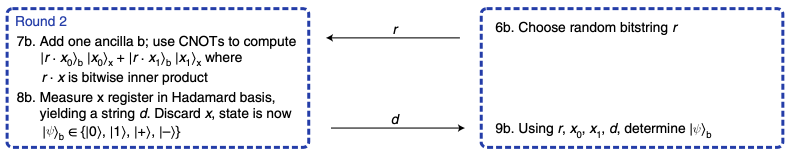

## Protocol Step 6b

This step consists simply in the generation of a random number between $0$ and $2^n-1$ where $n$ is the bit size of its the binary representation. The bit size of $r$ has to be the same size of the $x$ register.
Its actual implementation is done in the test code of the protocol step 7b and in the code for the whole protocol.

## Protocol Step 7b

Let's write the step 7b

**Step 7b**
* Add one ancilla $b$
* Use CNOTS to compute
$$
|r \cdot x_0 \rangle_b |x_0\rangle_x + |r \cdot x_1 \rangle_b | x_1\rangle_x
\tag{1}
$$
where $r\cdot x$ is bitwise inner product.

#### A couple of notes about the "bitwise inner product"
* Often and interchangebly, the bitwise inner prodcut is also called "binary" inner product, or also bitwise (or binary) "dot" product.
* The paper does not mention it, but since the ancilla register is constituted by only one qubit, the bitwise inner product has to be modulo 2. Indeed, that bitwise inner product should be written as $(r \cdot x) \!\!\!\mod  \!\! 2$ (as written in some Classiq documentation), not simply $(r \cdot x)$.
Thus the sum in the bitwise inner product, over the bit digits, should be modulo 2. Or, equivalently, it should be the result of a sequence of $\oplus$ (addition modulo 2, or XOR) operations (i.e. the sum of the bit products, $p_0$, $p_1$, $p_2$, $\dots$ should be $(((p_0 \oplus p_1) \oplus p_2) \oplus$ $\dots$) and so on).


### Let's examine how to implement the step 7b

Before the step 7b, the state of the circuit is given by the superposition in the $x$ register
$$ (|x_0\rangle + | x_1\rangle)_x ,
\tag{3}
$$
(we have already discarded the $y$ register).

We add an ancilla register $b$ constituted by only one qubit, so the state of the circuit is
$$ | 0 \rangle_b (|x_0\rangle + | x_1\rangle)_x .
\tag{4}
$$

So we need to compute the bitwise inner product between $x$ and $r$ and store it in the ancilla qubit.

Note that since the state of the $x$ register is in superosition between the states $|x_0\rangle$ and $| x_1\rangle$, if the unitary operation of computation of the prodcut is controlled by the state of the register $x$, automatically we obtain the desired state (Eq. 1).

The bitwise inner product $(r\cdot x) \!\!\! \mod \!\! 2$ is the defined as the sum of the product beteween respective bits of $r$ and $x$:
$$
(r \cdot x) \!\!\!\! \mod \!\! 2 = \left( \sum_{i=0}^{n-1} r_i x_i \right) \!\!\!\!\! \mod \!\! 2
$$
where $n$ is the size of the bit strings $r$ and $x$ (by protocol contruction $r$ is chosen to be the same size of $x$) and $r_i,x_i \in \{0,1\}$ are the bit values in the strings.

Each bit product $r_i x_i $ is $1$ only if both $r_i$ and $x_i$ are $1$ ($r_i =x_i =1$), and $0$ in the other three cases. So to implement each bit product $r_i x_i $ we can use a simple CNOT controlled by $x_i$ when $r_i = 1$. So the CNOTs are applied in the circuit only to the qubits with index $i$ for wich $r_i$ is equal to $1$, i.e. $i \in \{i: r_i = 1\}$).

The $\textrm{mod} \ 2$ of the sum is automatic, since every CNOT negates the current state of ancilla qubit. So the first CNOT produces 1, the second negates 1, so produces 0, i.e. has performed the sum $1+1$ modulo 2, and so on.

### Implemenation of the step 7b using Classiq Python SDK

For the implementation to Qmod/Classiq Python DK we can exploit the high level representation of Quantum Numbers and functions like `repeat` and the `if_`.

Here the `if_` function is used to make a classical condition on the application of the CNOTS. The condition is made on $r_i$.

In the implemantation we consider $r$ as integer and extract $r_i$ from it through the arithmetic expression $\big\lfloor \frac{r}{2^i} \big\rfloor\, \textrm{mod} \, 2$.

### Defintion the function of step 7b (function name: `bitwise_inner_product_mod2`)

In [ ]:
############## Developed by #########################
 # Filippo Tramonto
###################################################
from classiq import *
from classiq.qmod.symbolic import floor
@qfunc
def bitwise_inner_product_mod2(r: CInt, x: QArray[QBit], b: QBit) -> None:
    repeat(
        x.len,
        lambda i:
            if_(
                floor(r / 2**i) % 2 == 1, # it means r_i == 1, where r_0 is the most sigificant digit,
                                          # and r_{x.len-1} is the least signifcant digit
                lambda: CX(x[i], b)
            )
    )

## Protocol Step 8b

**Step 8b**
* Measure $x$ register in Hadamard basis yelding a string $d$.
* Discard $x$, the state is now
$$
|\psi \rangle_b \in \{|0\rangle, | 1\rangle,|+\rangle,|-\rangle\}
\tag{2}
$$

### Implemenation of the step 8b using Classiq Python SDK

The step 8b is the measurement of $x$ register in Hadamard basis, so in Qmod/Classiq Python DK it's just application the **Hadamard transform** function, before the measurement.

In Qmod/Classiq Python DKthe measrument gates or functions are not present. The measurement is made automatically when the quantum program is executed with on "normal" simulator (not the statevector simulator) or on the real quantum hardware.

In Qmod/Classiq Python DKthere is the builtin quantum function for the Hadamard transform `hadamard_transform`, that is simply the application of an Hadamard gate to each qubit of the quantum register (QArray or QNum) passed as input to the function.

### Testing the function of step 7b

The protocol requires that in the step 8b we measure the $x$ register of the state obtained from the step 7b in the Hadamard basis, but before that we neeed to test the step 7b, so will measure the ancilla qubit $b$ to check if the bitwise inner product modulo 2 was actually computed.

In order to test the function `bitwise_inner_product_mod2` we prepare the $x$ register in a state $|x\rangle$.

For test purpose we randomly chose $x$ as unsigned integer. The number has to be of a certain size in terms of bits, so we choose a bit size $m$ and choose $x$ in the range $[0,2^{m}-1]$.

The bitstring $r$ has to be the same bitstring size of $x$, we also randomly choose $r$ as unsigned integer number in the range $[0,2^{m}-1]$.

In the below cells, we define also a classical function to compute the the inner product between $r$ and $x$ to check the correctness of the result.

#### Definition of the classical function to compute bitwise inner product modulo 2 (functon name: `classical_bitwise_dot_prod_mod2` )



In [ ]:
# classical function of bitwise inner product modulo 2 (dot product and innter product are synonyms)
def classical_bitwise_dot_prod_mod2(x,r,m):
    dot_prod=0
    for i in range(m):
        r_i = math.floor(r / 2**i) % 2
        x_i = math.floor(x / 2**i) % 2
        dot_prod += r_i * x_i
    dot_prod = dot_prod % 2
    return dot_prod

#### Code and run of the test of the quantum function `bitwise_inner_product_mod2` of step 7b

In [ ]:
############## Developed by #########################
 # Filippo Tramonto
###################################################
m=4                    # it is just an example
cx = random.randrange(0,2**m) # classical value of x; 2**m is excluded
print("cx:",cx)

r = random.randrange(0,2**m)
print("r:",r)

@qfunc
def main(b: Output[QBit]): # we set as output argument only the ancilla qbit b, since we want measure only this for testing

    allocate(1,b)
    x = QNum('x')
    allocate_num(m,False,0,x) # if I use prepare_it (instead of inplace_prepare_int) allocate_num is not needed
    inplace_prepare_int(cx,x)

    bitwise_inner_product_mod2(r, x, b)

qmod = create_model(main)

# to run on Colab (the exception is excecuted only the first time you run in the current Colab session)
try:
    quantum_program = synthesize(qmod)
#except ClassiqAPIError:     # this does't work, it does not recognize the name "ClassiqAPIError"
except Exception:            # this captures every error...
    print("CLICK ON THE BELOW LINK TO CONFIRM THE AUTHENTICATION")
    classiq.authenticate(overwrite=True)
    quantum_program = synthesize(qmod)

job = execute(quantum_program)
print(
    f"The job on the provider {job.provider} on the backend {job.backend_name} with {job.num_shots} shots is {job.status} can be accessed in the IDE with this URL: {job.ide_url}"
)

print("m =",m,", cx =",cx,", r =",r)

results = job.result()[0].value
print("Quantum result:",results.parsed_counts)

prod = classical_bitwise_dot_prod_mod2(m,cx,r)
print("Classical result:",prod)

cx: 14
r: 15
Your user code: VZJG-XHXN
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=VZJG-XHXN
The job on the provider Classiq on the backend simulator with 2048 shots is QUEUED can be accessed in the IDE with this URL: https://platform.classiq.io/jobs/992d63b0-10fe-4cb7-bca7-421b67c06d58
m = 4 , cx = 14 , r = 15
Quantum result: [{'b': 1.0}: 2048]
Classical result: 1


## Protocol Step 9b

The **Step 9b** of the protocol is :
* Using $r$, $x_0$, $x_1$, $d$, determine $| \psi \rangle_b $

As stated in the paper, after the step 8b, i.e. after the measurement of $x$ register in Hadamard basis, the state of ancilla $b$ register is in the state $| \psi \rangle_b = (-1)^{d \cdot x_0}| r \cdot x_0 \rangle_b + (-1)^{d \cdot x_1} | r \cdot x_1 \rangle_b $, which is one of the states $\{ |0\rangle, |1\rangle, |+\rangle, |-\rangle \}$.

The step 9b of the protocol consists in classically compute the $4$ bitwise inner products modulo $2$, $d \cdot x_0$, $d \cdot x_1$, $r \cdot x_0$, $r \cdot x_1 $, and then select the correct state depending on the compbination of the $4$ results of the products.

The $2$ products $r \cdot x_0$, $r \cdot x_1 $ determine whether each state of $| r \cdot x_0 \rangle_b$,  $| r \cdot x_1 \rangle_b$ is $| 0 \rangle$ or $| 1 \rangle$.  The $2$ products $d \cdot x_0$, $d \cdot x_1$ determine the sign of each the state in superpostion.
Thus, after the computation of the procuts, we will obtain one of the states given by $\pm| 0 \ \textrm{or} \ 1 \rangle \pm| 0 \ \textrm{or} \ 1 \rangle $.

In general since for each bitwise inner product modulo $2$ the result is $0$ or $1$ and we have $4$ products, we have $16$ possible combinations of the results, but actually, listing all the cases, they reduces to $8$ possible different states taking account of the global phase. Since the global phase has no effect on the measurement, by removing also the states that differ by a global phase $-1$, the states reduces to the $4$ ones expected.

Therefore, after the computation of the $4$ products we have to cast the $16$ combinations of results to the $4$ states.

In cells above (for testing step 7b) we have already implemented the classical function to compute the bitwise inner product modulo 2 so we will re-use it.

### Defintion of the function of step 9b (function name: `determine_state_psi_b`)

In [ ]:
############## Developed by #########################
 # Filippo Tramonto
###################################################

# Note: r, d, x0, x1 are integer
def determine_state_psi_b(r,d,x0,x1):

    r_dot = np.empty(2,int)     # we use numpy to use to xor a list with a scalar, with ^
    d_dot = np.empty(2,int)
    r_dot[0] = classical_bitwise_dot_prod_mod2(r,x0,n_x) # r.x0 mod2
    r_dot[1] = classical_bitwise_dot_prod_mod2(r,x1,n_x) # r.x1 mod2
    d_dot[0] = classical_bitwise_dot_prod_mod2(d,x0,n_x) # d.x0 mod2
    d_dot[1] = classical_bitwise_dot_prod_mod2(d,x1,n_x) # d.x1 mod2
    print("[r.x0, r.x1]=",r_dot)
    print("[d.x0, d.x1]=",d_dot)

    # below we use all() function that returns 1 if all values of the list are 1
    # we use also xor operator ^ to filp all values of the list to make all() returns 1 when all list values are zero

    # for state |0>
    # if r.x0 = r.x1 = 0 and d.x0 = d.x1 = {0 or 1}
    if all(r_dot^1) and (all(d_dot) or all(d_dot^1)):
        return "|0>"

    # for state |1>
    # if r.x0 = r.x1 = 1 and d.x0 = d.x1 = {0 or 1}
    if all(r_dot) and (all(d_dot) or all(d_dot^1)):
        return "|1>"

    # for state |+>
    # if r.x0 != r.x1 and (d.x0 = d.x1 = {0 or 1} )
    if r_dot[0]!=r_dot[1] and (all(d_dot) or all(d_dot^1)):
        return "|+>"

    # for state |->
    # if r.x0 != r.x1 and d.x0 != d.x1
    if r_dot[0]!=r_dot[1] and d_dot[0]!=d_dot[1]:
        return "|->"

    # for combinations not correspondent to a quantum state
    # if (r.x0 = r.x1 = {0 or 1} and d.x0 != d.x1
    if (all(r_dot) or all(r_dot^1)) and d_dot[0]!=d_dot[1] :
        print("combination not correspondent to a state!")
        return None

### Test of the function of step 9b (`determine_state_psi_b`)

In [ ]:
import random
n_x = 4
x0 = random.randrange(0,2**n_x)
while True:
    x1 = random.randrange(0,2**n_x)
    if x1 != x0: break
while True:
    d = random.randrange(0,2**n_x)
    if d != x0 and d != x1: break
r = random.randrange(0,2**n_x)
print("r=",r,", d=",d,", x0=",x1,", x0=",x1)

state = determine_state_psi_b(r,d,x0,x1)
print("state is",state)

r= 2 , d= 1 , x0= 13 , x0= 13
[r.x0, r.x1]= [0 0]
[d.x0, d.x1]= [0 1]
combination not correspondent to a state!
state is None


# Round 3

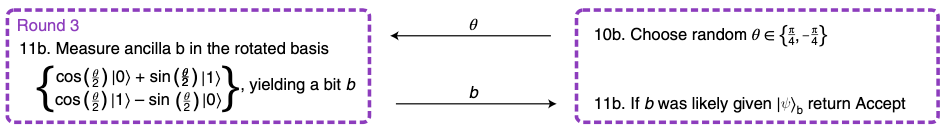

#### Protocol steps of round 3

Let's write the steps 10b and 11b-prover and 11-verifier of the paper as illustrated in the Fig. 1 of the paper.

**Step 10 b**

*  Choose random  $\theta \in \{\frac{\pi}{4}, -\frac{\pi}{4} \}$

**Step 11 b - prover**

* Measure ancilla b in the rotated basis
\begin{Bmatrix}
\cos\left(\frac{\theta}{2}\right) | 0 \rangle  +\sin\left(\frac{\theta}{2}\right)| 1 \rangle  \\
  \cos\left(\frac{\theta}{2}\right)| 1 \rangle - \sin\left(\frac{\theta}{2}\right)| 0 \rangle
\end{Bmatrix}
yielding a bit $b$

**Step 11 b - verifier**

* If $b$ was likely given $|\psi \rangle_b$ return Accept.

## Step 10 b


This step is easily implemented using the Python function `choice`, that randomly select an element from a list. In this case the list is composed by 2 elements: $\left[\frac{\pi}{4}, -\frac{\pi}{4} \right]$.

## Step 11 b - prover

We can implement measurment in the indicated rotated basis, by simply applying, before the actual measurement in the computational basis, the $RY(\theta)$ operator to the ancilla qubit $b$, that applies the required rotation, that is the $Y$ rotation of $\theta$ (i.e. the rotation of $\theta$ around the $y$ axis on the Bloch sphere).

The $RY(\theta)$ operator is defined by the matrix

\begin{pmatrix}
\cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\
\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)
\end{pmatrix}

If we apply this operator to the computational basis $| 0 \rangle$, $| 1 \rangle$ we obtain

$$
RY(\theta) | 0 \rangle = \cos\left(\frac{\theta}{2}\right) | 0 \rangle  + \sin\left(\frac{\theta}{2}\right)| 1 \rangle  \ , \\
 RY(\theta) | 1 \rangle =  - \sin\left(\frac{\theta}{2}\right) | 0 \rangle + \cos\left(\frac{\theta}{2}\right)| 1 \rangle
$$

that are exactly the roteted basis states required by the protocol step for the measurement of the ancilla qubit $b$.

#### Function defintion (function name: `measure_ancilla_in_rotated_basis`)

In [ ]:
############# Developed by #########################
# Nahid Binandeh Dehaghani
###################################################
############# Reviewed and edited by ###############
# Filippo Tramonto
##################################################
from classiq.execution import *

@qfunc
def measure_ancilla_in_rotated_basis(ancilla: QBit):
    global chosen_theta
    RY(chosen_theta, ancilla)

#### Test of the function for step 11b-prover, `measure_ancilla_in_rotated_basis`

In [ ]:
############## Developed by #########################
# Nahid Binandeh Dehaghani
###################################################
############# Reviewd by ##########################
# Filippo Tramonto
##################################################
@qfunc
def main(q: Output[QBit]):
    # Allocate a qubit
    allocate(1, q)

    # Prepare the state
    state = random.choice(['|0⟩', '|1⟩', '|+⟩', '|−⟩'])
    if state == '|1⟩':
        X(q)
    elif state == '|+⟩':
        H(q)
    elif state == '|−⟩':
        X(q)
        H(q)

    print(f"Chosen state: {state}") # Print the chosen state for debugging
    # Measure the qubit in a rotated basis
    measure_ancilla_in_rotated_basis(q)

chosen_theta = random.choice([math.pi / 4, -math.pi / 4])
print(chosen_theta)          # Print the chosen theta for debugging

# Create the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
job = execute(qprog)
results = job.result()
print("Job results:", results)

0.7853981633974483
Chosen state: |+⟩
Opening: https://platform.classiq.io/circuit/709dbb95-1671-440c-adad-6a52a3ca5e7f?version=0.44.0
Job results: [TaggedExecutionDetails(value_type=<SavedResultValueType.ExecutionDetails: 'ExecutionDetails'>, name='result', value=ExecutionDetails(vendor_format_result={}, counts={'1': 1753, '0': 295}, counts_lsb_right=True, parsed_states={'1': {'q': 1.0}, '0': {'q': 0.0}}, histogram=None, output_qubits_map={'q': (0,)}, state_vector=None, parsed_state_vector_states=None, physical_qubits_map={'q': (0,)}, num_shots=2048))]


## Step 11 b - verifier



In order to implement this step we need to compute all the probabilities of measuring the computational basis states $| 0 \rangle$, $| 1 \rangle$ of ancilla qubit $b$, when  $RY(\theta)$ is applied to the state $|\psi\rangle_b$, for all possible states $| 0 \rangle$, $| 1 \rangle$, $| + \rangle$, $| - \rangle$, and for the two values of $\theta \in \{ \frac{\pi}{4}, -\frac{\pi}{4}\}$. Thus there are $8$ pairs of probabilities for measuring the two computational basis states, in total $16$ probabilities.

The outcome of the measurement is the bit $b$.

Without showing all copmutations, let's illustrate the key elements of computations.

Let's apply $RY(\theta)$ to the states Hadamard basis states $| + \rangle$, $| - \rangle$. Using the expressions in the section above "Step 11b - prover" for the computational basis, we obtain

$$
RY(\theta) | + \rangle =
   \frac{1}{\sqrt{2}} RY(\theta)\left( | 0 \rangle + | 1 \rangle \right) =
   \frac{1}{\sqrt{2}}\left[
        \left( \cos\left(\frac{\theta}{2}\right) - \sin\left(\frac{\theta}{2}\right) \right)| 0 \rangle
       +\left( \cos\left(\frac{\theta}{2}\right) + \sin\left(\frac{\theta}{2}\right) \right)| 1 \rangle \right] \ ,\\
 RY(\theta) | - \rangle =
   \frac{1}{\sqrt{2}} RY(\theta)\left( | 0 \rangle - | 1 \rangle \right) =
   \frac{1}{\sqrt{2}}\left[
        \left( \cos\left(\frac{\theta}{2}\right) + \sin\left(\frac{\theta}{2}\right) \right)| 0 \rangle
       +\left(  \sin\left(\frac{\theta}{2}\right) -\cos\left(\frac{\theta}{2}\right) \right)| 1 \rangle \right]
$$

Let's compute the expressions of the probabilities after the $Y$ rotaion  for the four states of $|\psi\rangle_b$.

From the expressions for the two states $RY(\theta)| 0 \rangle $ and $RY(\theta)| 1 \rangle $ we find that the possible values of  the probabilties for the two computational basis states are given by $\cos^2\left(\frac{\theta}{2}\right)$ and $\sin^2\left(\frac{\theta}{2}\right)$.
These probabilities are the same if we substitute $\theta$ with  $\frac{\pi}{4}$ or $-\frac{\pi}{4} $, since they are indpendent from the sign of $\theta$. Subsituing $\theta$ with $\frac{\pi}{4}$, or $-\frac{\pi}{4}$, we have $\cos^2\left(\frac{\pi}{8}\right) \approx 0.85$ and $\sin^2\left(\frac{\pi}{8}\right) \approx 0.15$.

For the other states, $RY(\theta)| + \rangle $ and $RY(\theta)| - \rangle $, from the expressions showed above we find that the possible values of the probabilities  for the two computational basis states are given by two expressions
$$
\left(  \cos\left(\frac{\theta}{2}\right) + \sin\left(\frac{\theta}{2}\right)\right)^2 \ ,\\
\left(  \cos\left(\frac{\theta}{2}\right) -\sin\left(\frac{\theta}{2}\right) \right)^2 \ .
$$

Substituting $\theta$ with $\frac{\pi}{4}$ or $-\frac{\pi}{4} $, and making computations and simplificasions we obtain that the following equalities hold:

$$
\left(  \sin\left(\frac{\pi}{8}\right) +\cos\left(\frac{\pi}{8}\right) \right)^2 = \cos^2\left(\frac{\pi}{8}\right),\\
\left(  \sin\left(\frac{\pi}{8}\right) -\cos\left(\frac{\pi}{8}\right) \right)^2 = \sin^2\left(\frac{\pi}{8}\right)\ .
$$

Thus the two probablities for all $8$ possible final states after the $Y$ rotation are always given by $\cos^2\left(\frac{\pi}{8}\right) \approx 0.85$ and $\sin^2\left(\frac{\pi}{8}\right) \approx 0.15$, in different combinations for the two measured states $| 0 \rangle$, $| 1 \rangle$, depending from the intial state $|\psi\rangle_b$ before the rotation and from the rotation angle $\theta$.

Thus one of the computational states, $| 0 \rangle$ and $| 1 \rangle$, will be more likely than the other.

In the following we will list all these probabilities for the different outcomes $b$ depending from the state $|\psi\rangle_b$ and the rotation angle $\theta$.

For $|\psi\rangle_b \in \{ | 0 \rangle, | 1 \rangle \}$ the outcome probabilities do not depend from the sign of the angle thus the probabilities are the same for $\theta \in \{\frac{\pi}{4},-\frac{\pi}{4}\}$.

\begin{array}{ccc}
\hline
|\psi\rangle_b & P(0) & P(1) \\
\hline
|0\rangle_b & \cos^2\left(\frac{\pi}{8}\right) \approx 0.85 & \sin^2\left(\frac{\pi}{8}\right) \approx 0.15 \\
|1\rangle_b & \sin^2\left(\frac{\pi}{8}\right) \approx 0.15 &\cos^2\left(\frac{\pi}{8}\right) \approx 0.85 \\
\hline
\end{array}

Instead, for $|\psi\rangle_b \in \{ |  +\rangle, | - \rangle \}$ the outcome probabilities depend from the sign of the angle $\theta$ thus we will list also the cases for the two values $\{\frac{\pi}{4},-\frac{\pi}{4}\}$

\begin{array}{cccc}
\hline
|\psi\rangle_b & \theta &P(0) & P(1) \\
\hline
|+\rangle_b & \frac{\pi}{4} & \sin^2\left(\frac{\pi}{8}\right) \approx 0.15 &\cos^2\left(\frac{\pi}{8}\right) \approx 0.85 \\
|+\rangle_b & -\frac{\pi}{4} & \cos^2\left(\frac{\pi}{8}\right) \approx 0.85 & \sin^2\left(\frac{\pi}{8}\right) \approx 0.15 \\
|-\rangle_b & \frac{\pi}{4} & \cos^2\left(\frac{\pi}{8}\right) \approx 0.85 & \sin^2\left(\frac{\pi}{8}\right) \approx 0.15 \\
|-\rangle_b &  -\frac{\pi}{4} &\sin^2\left(\frac{\pi}{8}\right) \approx 0.15 &\cos^2\left(\frac{\pi}{8}\right) \approx 0.85 \\
\hline
\end{array}

With these lists of probabilites we can implement a function that return "Accept" if the bit $b$, outcome of the measurement of the ancilla qubit in the rotated basis, is the one with the highier probabilities ($\cos^2\left(\frac{\pi}{8}\right) \approx 0.85$) of the two possible values, $0$ and $1$, and return "Not accept" otherwise.





#### Defintion of the function of the Step 11b-verifier (function name: `final_verifier_validation`)

In [ ]:
############## Developed by #########################
# Filippo Tramonto
##################################################
def final_verifier_validation(psi_b,theta,b):

    if psi_b == "|0>":
        if b == 0:
            return True  # Accept
        else:
            return False # Not accept
    elif psi_b == "|1>":
        if b == 1:
            return True  # Accept
        else:
            return False # Not accept
    elif psi_b == "|+>":
        if theta == math.pi/4:
            if b == 1:
                return True  # Accept
            else:
                return False # Not accept
        elif theta == -math.pi/4:
            if b == 0:
                return True  # Accept
            else:
                return False # Not accept
    elif psi_b == "|->":
        if theta == math.pi/4:
            if b == 0:
                return True  # Accept
            else:
                return False # Not accept
        elif theta == -math.pi/4:
            if b == 1:
                return True  # Accept
            else:
                return False # Not accept

#### Test of the function for step 11b - verifier (`final_verifier_validation`)

In this test we will run the simulator with only one shot, to the only one measure of the qbuit b, for each of the 8 possible cases (4 states, 2 angles).

In [ ]:
############## Developed by #########################
# Filippo Tramonto
##################################################
execution_preferences=ExecutionPreferences(
    num_shots=1
)
@qfunc
def main(q: Output[QBit]):
    # Allocate a qubit
    allocate(1, q)

    # Prepare the state
    #state = random.choice(['|0>', '|1>', '|+>', '|->'])
    if state == '|1>':
        X(q)
    elif state == '|+>':
        H(q)
    elif state == '|->':
        X(q)
        H(q)

    print(f"Input State |psi_b>: {state}") # Print the chosen state for debugging
    # Measure the qubit in a rotated basis
    measure_ancilla_in_rotated_basis(q)

for state in ['|0>', '|1>', '|+>', '|->']:
    for chosen_theta in [math.pi / 4, -math.pi / 4]:
        print("theta=",chosen_theta)          # Print the chosen theta for debugging
        # Create the quantum model
        qmod = create_model(main)
        qmod = set_execution_preferences(qmod, execution_preferences)
        qprog = synthesize(qmod)
        job = execute(qprog)
        results = job.result()
        #print("num shots=",results[0].value.num_shots)
        #print(results[0].value)
        b = int(list(results[0].value.counts.keys())[0])
        print("b=",b)
        output = final_verifier_validation(state,chosen_theta,b)
        if output == None:
            raise ValueError("output = None !")
        if output:
            print("Accept!")
        else:
            print("Not accept!")

        print("=============================================")

theta= 0.7853981633974483
Input State |psi_b>: |0>
b= 0
Accept!
theta= -0.7853981633974483
Input State |psi_b>: |0>
b= 0
Accept!
theta= 0.7853981633974483
Input State |psi_b>: |1>
b= 1
Accept!
theta= -0.7853981633974483
Input State |psi_b>: |1>
b= 1
Accept!
theta= 0.7853981633974483
Input State |psi_b>: |+>
b= 1
Accept!
theta= -0.7853981633974483
Input State |psi_b>: |+>
b= 0
Accept!
theta= 0.7853981633974483
Input State |psi_b>: |->
b= 0
Accept!
theta= -0.7853981633974483
Input State |psi_b>: |->
b= 1
Accept!


# Whole protocol implemenation

## Implementation of whole quantum side of the protocol

However in the test section below we will use also the classical steps and functions of the protocol that have to be run before the quantum steps.

### Main function that includes all steps of the quantum prover

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################
@qfunc
def main(x: Output[QArray[QBit]], y: Output[QArray[QBit]], b: Output[QBit]) -> None:

    allocate(n_x,x)
    allocate(n_y,y)
    allocate(1,b)

    x2_mod_N_phase(x, y, N)             # step 2

    bitwise_inner_product_mod2(r,x,b)   # step 7b

    hadamard_transform(x)               # step 8b

    measure_ancilla_in_rotated_basis(b) # step 11b - qunatum prover

### Test function of the main function of quantum prover

In this test function, for running the quantum program, we used the Statevector simulator

#### Utility cell for the fucntion defined below

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################
from classiq.execution import ExecutionDetails
from classiq.qmod.symbolic import pi

# an utility function
def round_complex(x,digits):
    x_real = round(x.real,digits)
    x_imag = round(x.imag,digits)
    if x_real == 0:  # to force it to zero when after the round it's "-0.0"
        x_real = 0.0
    if x_imag == 0:
        x = round(x.real,digits)
    else:
        x = complex(x_real,x_imag)
    return x

## import and setting execution preferences to run on the statevector simulator
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.synthesis import set_execution_preferences

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)

execution_preferences=ExecutionPreferences(
    num_shots=1,
    backend_preferences=backend_preferences
)

#### Test Function definition

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################
def test_quantum_prover():
    print("N=",N)
    print("n_x:",n_x)
    print("n_y:",n_y)

    r = random.randrange(0,2**n_x)
    print("r:",r)

    @qfunc
    def main(x: Output[QNum], y: Output[QNum], b: Output[QBit]) -> None:

        allocate(n_x,x)
        allocate(n_y,y)
        allocate(1,b)

        x2_mod_N_phase(x, y)                # step 2

        bitwise_inner_product_mod2(r,x,b)   # step 7b

        hadamard_transform(x)               # step 8b

        measure_ancilla_in_rotated_basis(b) # step11b, qunatum prover

    ## creation of quantum model (it executes also the classical operations)
    qmod = create_model(main)

    ## setting execution preferences to run on the statevector simulator
    qmod = set_execution_preferences(
        qmod,
        execution_preferences=execution_preferences
    )
    write_qmod(qmod, f"whole_protocol_quantum_prover-N={N}")
    # quantum program synthesis
    qprog = synthesize(qmod)
    show(qprog)
    # quantum program execution
    job = execute(qprog)
    result = job.result()[0].value

    return result

### TEST execution with variable N

In next cell, we actually execute the test function and set the value of $N$ (only for the purpose of testing the main function for the quantum prover, it can be any value greater or equal than $3$ ($N \geq 3$) ) and the value of the parameter `n_extra_bits` for tuning the precision of the computation of $x^2 \mod N$. That is, it tunes the number of digits of the binary fraction $w$ (see the sub-section "Phase circuits for $x^2 \mod N$" in Methods section of the paper) used to represent $x^2 \mod N$ in the quantum state.


In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################
# input classical parameters
N = 33
n_extrabits = 0

# domain_max is the max value of the domain of x^2 mod N, i.e. the max value for x
# the domain of x^2 mod N, is [0,domain_max]
# the formula below means: if N is even, domain_max= N/2 -1 ; if N is odd domain_max= floor(N/2)
domain_max = (N+1)//2 - 1
n_x = domain_max.bit_length()
n_y = N.bit_length() + n_extrabits # in the orginal code: args.extra_bits
n_counter = n_x.bit_length()       # number of qubits of the ancilla register counter

# Protocol STEP 10b
chosen_theta = random.choice([math.pi / 4, -math.pi / 4])
print("chosen_theta=",chosen_theta)

# test execution
result=test_quantum_prover()

chosen_theta= 0.7853981633974483
N= 33
n_x: 5
n_y: 6
r: 27
Opening: https://platform.classiq.io/circuit/e5dc3867-cefa-417c-998d-02134010f59c?version=0.44.0


### Code cell with all post-processing

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################
# parsing of the results
parsed_state_vector = result.parsed_state_vector
def myFunc(e):
    return e.bitstring
parsed_state_vector.sort(key=myFunc)

n_good_y = 0
good_count = 0
x_y_prob= {}
for state in parsed_state_vector:
    #print(state.state,state.bitstring,round_complex(complex(state.amplitude),3))

    x = int(state.state['x'])
    w_int = int(state.state['y']) # it's the integer represenation of the bitstring of the binary fraction w
    w = w_int / 2**n_y  # the binary fraction w
    y = w * N

    ampl=state.amplitude
    prob = (ampl * np.conj(ampl) ).real

    key = (y, x)
    if key not in x_y_prob:
        x_y_prob[key] = 0
    x_y_prob[key] += prob

for key, val in x_y_prob.items():
    print(key,val)

(0.0, 0) 0.000983927310088212
(0.0, 1) 0.0010901259108096963
(0.0, 2) 0.001183646024636193
(0.0, 3) 0.0010237960550400383
(0.0, 4) 0.0009162272308091706
(0.0, 5) 0.001004631166566706
(0.0, 6) 0.0008130378073167339
(0.0, 7) 0.001106239491015953
(0.0, 8) 0.001004631166566706
(0.0, 9) 0.0009162272308091701
(0.0, 10) 0.0011062394910159531
(0.0, 11) 0.0008130378073167335
(0.0, 12) 0.0010901259108096954
(0.0, 13) 0.000983927310088211
(0.0, 14) 0.0010237960550400376
(0.0, 15) 0.0011836460246361917
(0.0, 16) 0.0010216850593912608
(0.0, 17) 0.0006863195026584118
(0.0, 18) 0.0009946616601358973
(0.0, 19) 0.0011826332311653538
(0.0, 20) 0.0010842127636933013
(0.0, 21) 0.0009572679889246484
(0.0, 22) 0.0009536923657027474
(0.0, 23) 0.0008881142813900833
(0.0, 24) 0.0009572679889246477
(0.0, 25) 0.0010842127636933006
(0.0, 26) 0.0008881142813900837
(0.0, 27) 0.0009536923657027471
(0.0, 28) 0.0006863195026584122
(0.0, 29) 0.0010216850593912602
(0.0, 30) 0.0011826332311653533
(0.0, 31) 0.000994661660

## Implementation of whole protocol with quantum part and classical parts

The only two inputs of the protocol are `n`, the number of bits for representing the primes $p$ and $q$, and `n_extrabits`, the number of extra bits to tune the precision of computation of $y = x^2 \!\!\! \mod \!\! N$,  i.e. for adding extra bits for improving the represenatation of the binary fraction $w= y/N - [Y/N]$ (that is the fractional part after substracting the integer part of $y/N$), $w = 0.w_{m-1} w_{m-2}\dots w_0$ (where $w_0$ is the least significant bit, and $m$ is the total number of bits to used (that is `n_y` in the code)).  The binary fraction $w = 0.w_{m-1} w_{m-2}...w_1 w_0$ is equal to the sum $w_{m-1}/2^1 + w_{m-2}/2^2 +\dots + w_0 / 2^{m}$. The fraction $w$ can be also computed by using the integer decimal represenation of the bitstring $w_{m-1} w_{m-2} \dots w_0$ and then divide it by $2^{m}$.

Here we use the staetvector simulator, that has not the measurements. Thus in order to have the 3 measurements required by the protocol (of registers $y$, $x$ and $b$), we will simulate the measurements in the post-processing of the statevector simulator results, by considering the probabilities obtained from the amplitudes of the output statevector.
In other words, the protocol steps 3, and the computational basis measurements of the step 8b and 11b-prover are implemented in the post-processing of the results of the statevector simulator.

### Code cell with the implementation of all steps of the protocol, except the measurements and the verifier steps of procol 4, 9b, and 11b-verifier, that have to be executed after the measurements

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################
n = 3     # the minum bit size n to represent p and q is 3
n_extrabits = 0

# Protocol STEP 1
N, p, q = gen_1lambda(n)

print(f"N= {N}, p= {p}, q= {q}")

#N = 5            # for debug
#print(f"N= {N}") # debug print

# domain_max is the max value of the domain of x^2 mod N, i.e. the max value for x
# the domain of x^2 mod N, is [0,domain_max]
# the formula below means: if N is even, domain_max= N/2 -1 ; if N is odd domain_max= floor(N/2)
domain_max = (N+1)//2 - 1
n_x = domain_max.bit_length()
n_y = N.bit_length() + n_extrabits # in the orginal code: args.extra_bits
n_counter = n_x.bit_length()       # number of qubits of the ancilla register counter

# Protocol STEP 6b
r = random.randrange(0,2**n_x)
print("r=",r,",in binary is =",bin(r)[2:])

# Protocol STEP 10b
chosen_theta = random.choice([math.pi / 4, -math.pi / 4])
print("chosen_theta=",chosen_theta)

print("n_x=",n_x)
print("n_y=",n_y)
print("n_counter=",n_counter)
print()

@qfunc
def main(x: Output[QNum], y: Output[QNum], b: Output[QBit]) -> None:
#def main(x: Output[QArray[QBit]], y: Output[QArray[QBit]], b: Output[QBit]) -> None:

    allocate(n_x,x)
    allocate(n_y,y)
    allocate(1,b)

    # Protocol STEP 2
    x2_mod_N_phase(x, y)

    # Protocol STEP 7b
    bitwise_inner_product_mod2(r,x,b)

    # Protocol STEP 8b
    hadamard_transform(x)

    # Protocol STEP 11b-prover
    measure_ancilla_in_rotated_basis(b)

# Creation of quantum model
qmod = create_model(main)

# Setting execution preferences to run on the statevector simulator
qmod = set_execution_preferences(
    qmod,
    execution_preferences=execution_preferences
)
print()
print("Synthesizing...") # debug print
# Synthsize the quantum program
qprog = synthesize(qmod)
show(qprog)

# execution of the quantum program
print("Executing quantum program...") # debut print
job = execute(qprog)
print("Number of shots:",job.num_shots)
print("Provider:",job.provider)
print("Backend:",job.backend_name)
print("Status:",job.status)
print("URL:",job.ide_url)
print()
result = job.result()[0].value
print("Quantum program execution finished!") # debug print

N= 21, p= 7, q= 3
r= 6 ,in binary is = 110
chosen_theta= 0.7853981633974483
n_x= 4
n_y= 5
n_counter= 3


Synthesizing...
Opening: https://platform.classiq.io/circuit/480c1725-cb0e-4454-b845-1ee3d3e41a13?version=0.44.0
Executing quantum program...
Number of shots: 1
Provider: Classiq
Backend: simulator_statevector
Status: JobStatus.QUEUED
URL: https://platform.classiq.io/jobs/f6aa1ca9-321d-404d-961f-8029cd9df99f

Quantum program execution finished!


### Code cell with all post-processing part, including the simulation of the measurement and the classical verifier protocol steps 4, 9b and 11b-verifier

In [ ]:
############## Developed by #########################
  # Filippo Tramonto
###################################################

## In this cells the MEASUREMENTS of the STEPS 3, 8b, and 11b-prover of the protocol
## are performed trough a simulation of the measurement of the registers using
## the probabilities obtained from the statevector and the classical verifier protocol steps
## 4, 9b and 11b-verifier are performed

# parsing of the results
parsed_state_vector = result.parsed_state_vector
def myFunc(e):
    return e.bitstring
parsed_state_vector.sort(key=myFunc)

xy_prob = {}
xyb_prob = {}
y_prob= {}
y_x = {}
for state in parsed_state_vector:
    #print(state.state,state.bitstring,round_complex(complex(state.amplitude),3)) # debug print

    x = int(state.state['x'])

    w_int = int(state.state['y']) # it's the integer represenation of the bitstring of the binary fraction w
    w = w_int / 2**n_y  # the binary fraction w
    y = w * N

    b = int(state.state['b'])

    ampl=state.amplitude
    prob = (ampl * np.conj(ampl) ).real # compute the probability for each state

    # build the dictionary of probabilities for each pairs (x,y)
    key = (x,y)
    if key not in xy_prob:
        xy_prob[key] = 0
    xy_prob[key] += prob

    # build 2 dictionaries: one of proabilities for each y, one of lists of x's for each y
    # NOTE: here the x's are not the original x's, but the d values obtained by measuring
    #       the x register in Hadamard basis
    if y not in y_prob:
        y_prob[y] = 0
        y_x[y] = []
    y_prob[y] += prob
    if x not in y_x[y]:
        y_x[y].append(x)

    # build the dictionary of probabilities for each tuples (x,y,b)
    key = (x,y,b)
    if key not in xyb_prob:
        xyb_prob[key] = 0
    xyb_prob[key] += prob

###### MEASUREMENT of y register of PROTOCOL STEP 3 ################
### In the foloowing, we simulate the mesurement of y, discarding the not valid ones,Protocol step 4
# get the two list to input to the function random.choices
y_list = list(y_prob.keys())      # list of y's
prob_list = list(y_prob.values()) # list of prob's
while True:      # iterate until a valid y is found
    # choose randomly y, following the y probabilities, to simulate the measurement of y
    chosen_y = random.choices(y_list, weights=prob_list, k=1)[0] # [0] because it's a list with 1 element
    #print(chosen_y)

    x_res = compute_x0x1(round(chosen_y), p, q) # round because y is approximated
    if x_res != None:
        x0 = x_res[0]
        x1 = x_res[1]
        break
print("MEASUREMENT OF y register DONE! (discarding not valid y)")
print("Measured y:",chosen_y)
print("Classically computed x0 and x1, from measured y, and the primes p and q:")
print("x0=",x0,"x1=",x1)
print()

######## MEASUREMENT of x register of PROTOCOL STEP 8b, obtaining d ##############
# extract all possible bitstrings d could be obtainded by measuring x register and their probabilities
ychosen_x_list = y_x[chosen_y]
x_ychosen_prob_list = []
for x in ychosen_x_list:
    x_ychosen_prob_list.append(xy_prob[(x,chosen_y)])
# choose randomly d among the possible d's, following the d probabilities, to simulate the x register measurement
d = random.choices(ychosen_x_list, weights=x_ychosen_prob_list, k=1)[0] # [0] because it's a list with 1 element
print("MEASUREMENT OF x register DONE!")
print("Measured d:",d)
print("As bitstring:",bin(d)[2:])
print()

## PROTOCOL STEP 9B
psi_b = determine_state_psi_b(r,d,x0,x1)
print("DETERMINED classically the STATE psi_b, from r, x0, x1, d!!")
print("State psi_b:",psi_b)
print()

# MEASUREMENT of ancilla qbuit b PROTOCOL STEP 11b-prover
# extract the probabilities for the measured b (0 or 1)
b_list = [0,1]
d_ychosen_b_prob_list= [ xyb_prob[(d,chosen_y,b)] for b in b_list]
# choose randomly d among the possible d's, following the d probabilities, to simulate the x register measurement
b = random.choices(b_list, weights=d_ychosen_b_prob_list, k=1)[0] # [0] because it's a list with 1 element
print("MEASUREMENT OF anctilla qubit b DONE!")
print("Measured b:",b)
print()
print("chosen theta:",chosen_theta)
output = final_verifier_validation(psi_b,chosen_theta,b)
if output == None:
    raise ValueError("output = None !")
if output:
    print("Accept!")
else:
    print("Not accept!")

MEASUREMENT OF y register DONE! (discarding not valid y)
Measured y: 3.9375
Classically computed x0 and x1, from measured y, and the primes p and q:
x0= 2 x1= 5

MEASUREMENT OF x register DONE!
Measured d: 5
As bitstring: 101

[r.x0, r.x1]= [1 1]
[d.x0, d.x1]= [0 0]
DETERMINED classically the STATE psi_b, from r, x0, x1, d!!
State psi_b: |1>

MEASUREMENT OF anctilla qubit b DONE!
Measured b: 1

chosen theta: 0.7853981633974483
Accept!


# We mesure the resources of the quantum circuit

In this section of the notebook, for the "quantum resource estimation" requirement of the project of the Step 2, we will "measure" the resource data, like width, depth , and CX count, associated to the quantum circuit for increasing sizes of the problem size, that in our case deppends mainly by the  modulus $N$. Another parameter that affect the size of the circuits is the number of extra bits for increasing the accuracy of the measured value of $y = x^2 \!\!\! \mod \!\! N$.

Here we chose do not synthesize the quantum program of whole side of quantum program, but we chose to syntesize the quantum program of the "phase circuit fast".

In the following, we will syntesize the quantum program for increasing sizes of the quantum registers, that depends from the value of the modulus $N$.

Here, to generate the inscreasing values of valid $N$, we will use the our deveolped function `gen_1lambda()` that takes as input $n$ the number of bits needed to represent the primes, factors of $N$, and radomly samples the valid primes in the whole range from 3 to the size dictated by $n$. Thus for increasing $n$ it could be also ramdomly choose low values of the primes alread generated in the previous iterations. For this reason in the code below we will impose the constraints for the value of $N$ such that the lenght of $x$ register is increased by 1 at each iteration.


In [ ]:
# Measure the resources
import time

def measure_phase_circuit(max_nx,optim_param):  ## max_nx is the max n_x (lenght of x register)
                                                ## optim_param is the optimization_paramter setting
    if max_nx < 4:
        raise ValueError("not allowed value of max_nx! it has to be >= 4.")

    #preferences = Preferences(
    #custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    #random_seed=1235,
    #optimization_timeout_seconds=100,
    #transpilation_option="custom",
    #)

    n_x_list =[]
    depths = []
    cx_counts = []
    u_counts = []
    widths = []
    elapse_times = []
    # loop over the bit size of x register, from 4 (the min number for the
    # lowest valid N=21 for Rabin's TCF function) to max_nx
    for nn_x in range(4,max_nx+1):  # the name nn_x is used (instead of n_x) to prevent it
      print("nn_x = ", nn_x)        # from being overwritten by n_x initialized below
      while True:
        N, p, q = gen_1lambda(nn_x)
        if N // 2 >= 2**(nn_x-1) and N // 2 <= 2**nn_x -1: # if floor(N/2) is in [2^(n_x-1),2^n_x -1]
           break

      # Print the generated inputs
      print("N=",N)
      print(f"p: {p} q: {q}")
      # domain_max is the max value of the domain of x^2 mod N, i.e. the max value for x
      # the domain of x^2 mod N, is [0,domain_max]
      # the formula below means: if N is even, domain_max= N/2 -1 ; if N is odd domain_max= floor(N/2)
      domain_max = (N+1)//2 - 1
      n_x = domain_max.bit_length()
      n_y = N.bit_length() # in the orginal code: N.bit_length()+args.extra_bits
      print("n_x:",n_x)
      print("n_y:",n_y)
      # Defintion of the main quantum function
      @qfunc
      def main(x: Output[QNum], y: Output[QNum]):
          allocate(n_x,x)
          allocate(n_y,y)
          x2_mod_N_phase(x, y)
      ## creation of quantum model (it executes also the classical operations)
      qmod = create_model(main)

      qmod = set_constraints(qmod, Constraints(optimization_parameter=optim_param) )

      # We measure time taken for each running session
      start_time = time.time()  # Start time
      ## synthesize the quantum program
      qprog = synthesize(qmod)
      show(qprog)
      circuit = QuantumProgram.from_qprog(qprog)
      end_time = time.time()  # End time
      elapsed_time = end_time - start_time  # Calculate elapsed time
      print(f"Elapsed time: {elapsed_time:.2f} seconds")
      depths.append(circuit.transpiled_circuit.depth)
      cx_counts.append(circuit.transpiled_circuit.count_ops["cx"])
      u_counts.append(circuit.transpiled_circuit.count_ops["u"])
      widths.append(circuit.data.width)
      elapse_times.append(elapsed_time)
      n_x_list.append(n_x)
    return depths, widths, cx_counts, u_counts, n_x_list, elapse_times

In [ ]:
# Call the test function
### some optimization paramters available: "no_opt", "width", "depth"

max_nx = 8
print("With optimization options 'width': ")
width_optim_depths, width_optim_widths, width_optim_cx_counts, width_optim_u_counts, \
    n_x_list, width_optim_elaspe_times = measure_phase_circuit(max_nx,"width")
print()

print("With optimization options 'depth': ")
depth_optim_depths, depth_optim_widths, depth_optim_cx_counts, depth_optim_u_counts, \
    n_x_list, depth_optim_elaspe_times = measure_phase_circuit(max_nx,"depth")

# End of the test

With optimization options 'width': 
nn_x =  4
N= 21
p: 7 q: 3
n_x: 4
n_y: 5
Opening: https://platform.classiq.io/circuit/01f825c0-e652-4850-8a17-23b16e4bab95?version=0.44.0
Elapsed time: 22.71 seconds
nn_x =  5
N= 33
p: 3 q: 11
n_x: 5
n_y: 6
Opening: https://platform.classiq.io/circuit/fae1f370-4dda-4881-8ca9-d9b1749f8ca0?version=0.44.0
Elapsed time: 52.75 seconds
nn_x =  6
N= 93
p: 3 q: 31
n_x: 6
n_y: 7
Opening: https://platform.classiq.io/circuit/71b84347-06e5-4941-a82f-e0fc8ad0cff3?version=0.44.0
Elapsed time: 85.23 seconds
nn_x =  7
N= 201
p: 3 q: 67
n_x: 7
n_y: 8
Opening: https://platform.classiq.io/circuit/e6175e91-1f17-4b12-9cd2-d5af672bf953?version=0.44.0
Elapsed time: 36.12 seconds
nn_x =  8
N= 381
p: 127 q: 3
n_x: 8
n_y: 9


KeyboardInterrupt: 

In [ ]:
# Check results
print("n_x values:",n_x_list)
print()
print("data obtained with 'width' optimization option:")
print("classiq depths:", width_optim_depths)
print("classiq widths:", width_optim_widths)
print("classiq cx count:", width_optim_cx_counts)
print("classiq u count:", width_optim_u_counts)
print("Elapse time:", width_optim_elaspe_times)
print()
print("data obtained with 'depth' optimization option:")
print("classiq depths:", depth_optim_depths)
print("classiq widths:", depth_optim_widths)
print("classiq cx count:", depth_optim_cx_counts)
print("classiq u count:", depth_optim_u_counts)
print("Elapse time:", depth_optim_elaspe_times)

In [ ]:
# Call the test function
max_nx = 18
### some optimization paramters available: "no_opt", "width", "depth"

### call with no optimization parameter ("no_opt")
no_opt_depths, no_opt_widths, no_opt_cx_counts, no_opt_u_counts, \
    n_x_list, no_opt_elaspe_times = measure_phase_circuit(max_nx,"no_opt")
print()


In [ ]:
# Draw charts
import matplotlib.pyplot as plt

classiq_color = "#D7F75B"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

# Draw width
plt.plot(
    n_x_list,
    no_opt_widths,
    "bs-",
    label="width",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
)


plt.legend(fontsize=16, loc="lower right")
plt.ylabel("Width", fontsize=16)
plt.xlabel("x register lenght", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

## Draw depth
plt.plot(
    n_x_list,
    no_opt_depths,
    "o-",
    label="depth",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    color='blue'
)

# Draw CX gate
plt.plot(
    n_x_list,
    no_opt_cx_counts,
    "*-",
    label="cx gate",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=12,
    markeredgewidth=1.5,
)
# Draw U gate
plt.plot(
    n_x_list,
    no_opt_u_counts,
    "g^-",
    label="u gate",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=12,
    markeredgewidth=1.5,
)
# Draw elapse time
#plt.plot(
#    n_x_list,
#    width_optim_elaspe_times,
#    "r--",
#    label="elapse time",
#    markerfacecolor=classiq_color,
#    markeredgecolor="k",
#    markersize=12,
#    markeredgewidth=1.5,
#)

plt.legend(fontsize=16, loc="lower right")
plt.ylabel("Depth, CX, U", fontsize=16)
plt.xlabel("x register lenght", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()